Subset data shape: (10000, 32, 32, 3)
Data shape after resize & preprocess: (10000, 224, 224, 3)
625/625 ━━━━━━━━━━━━━━━━━━━━ 1204s 2s/step
Feature matrix shape: (10000, 2048)
K-means done. Labels shape: (10000,)
Clustering accuracy: 0.6691
Silhouette score: 0.03910012170672417


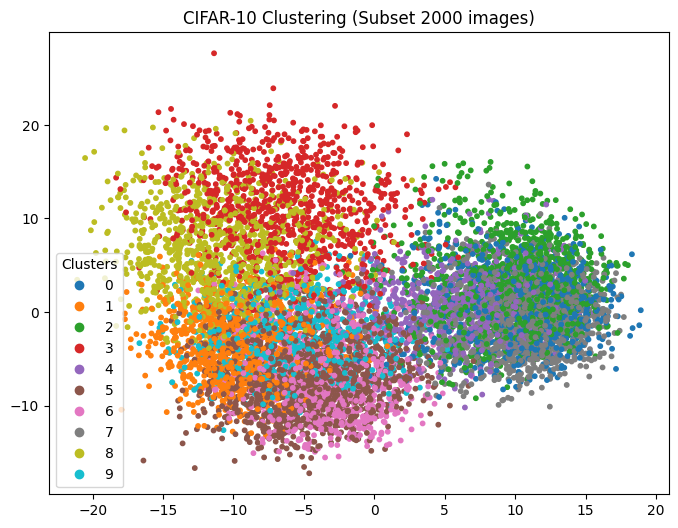

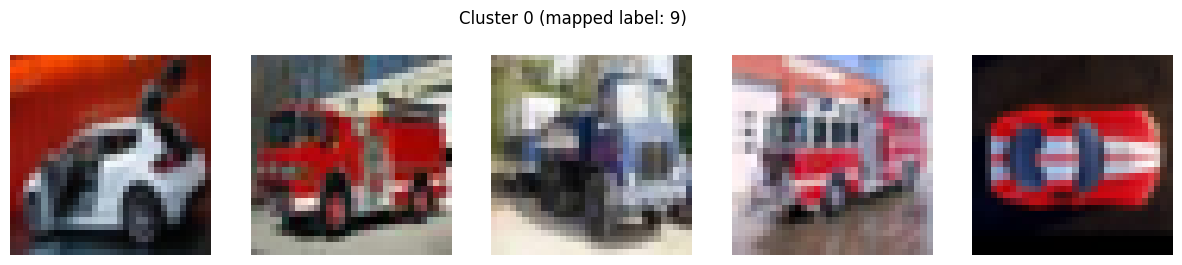

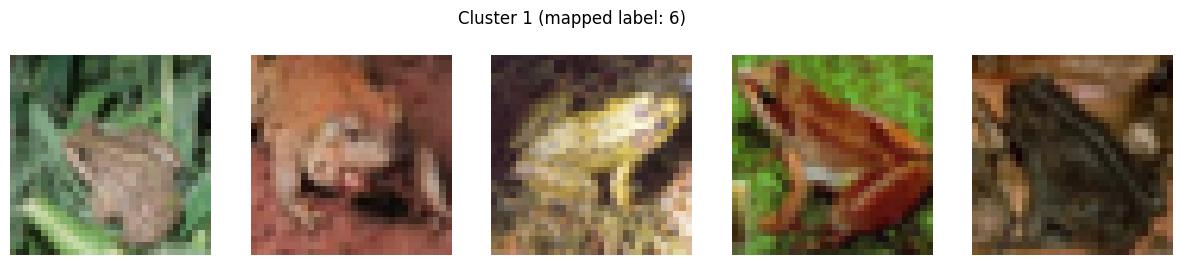

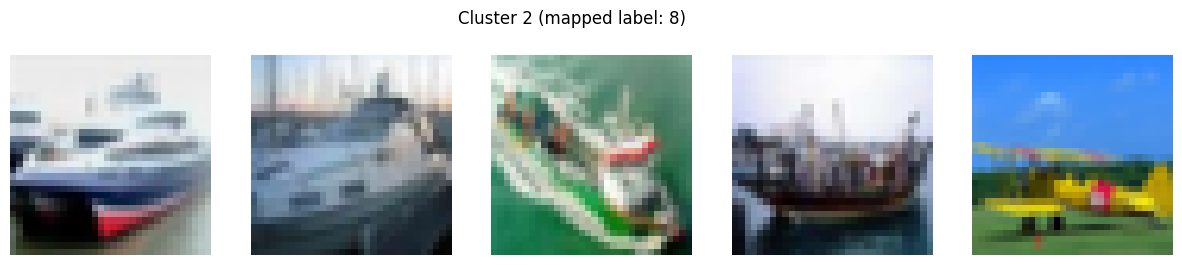

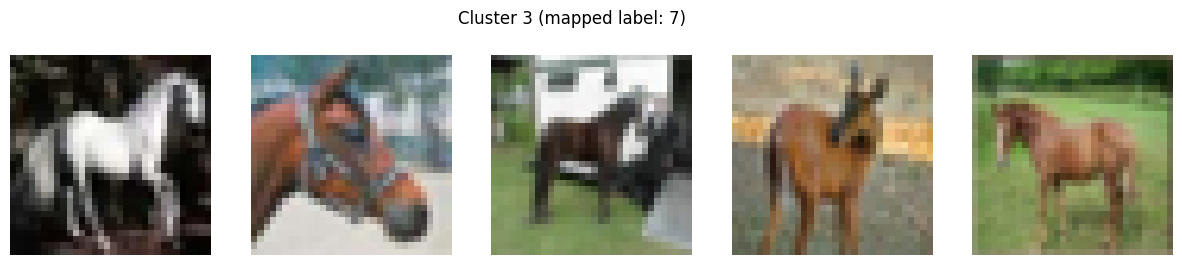

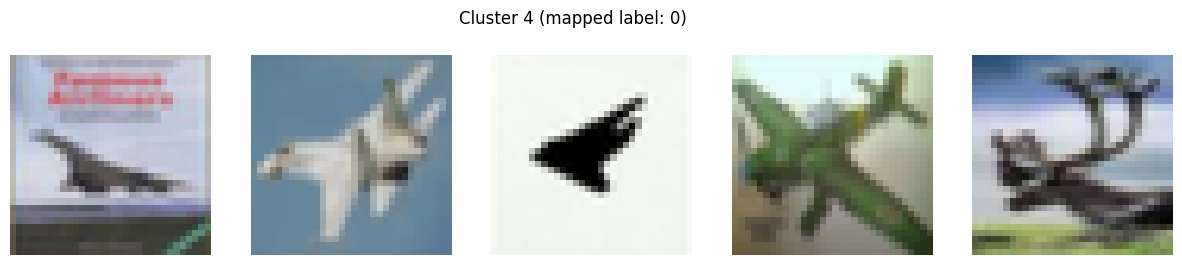

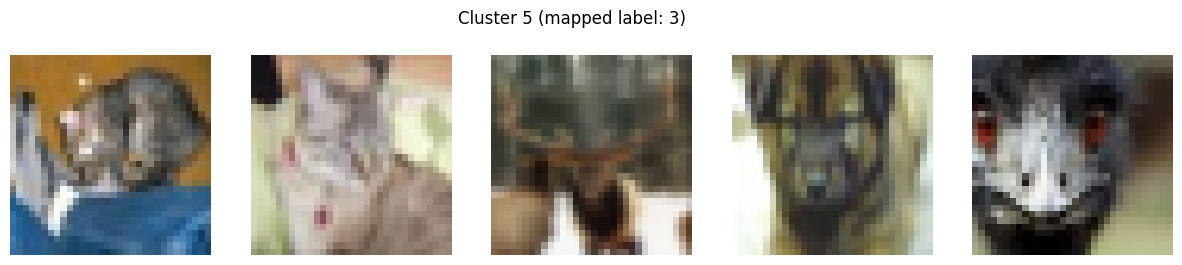

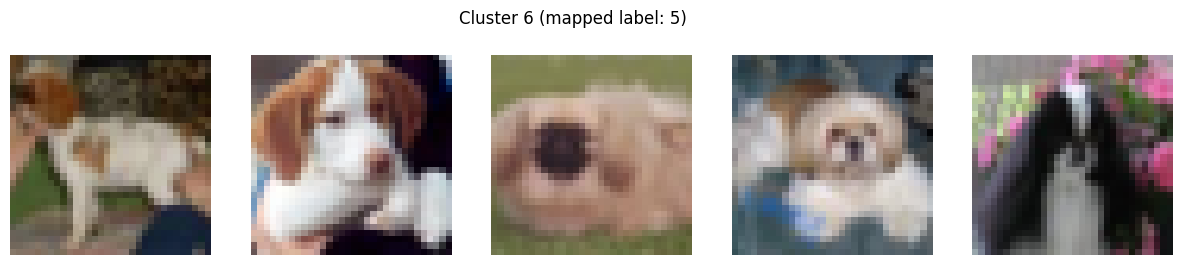

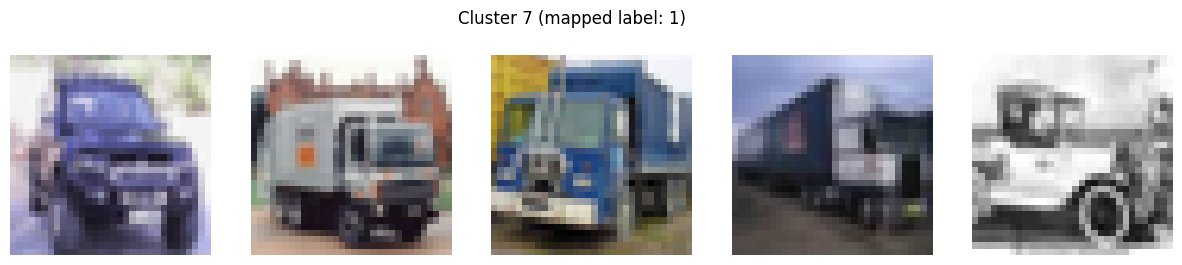

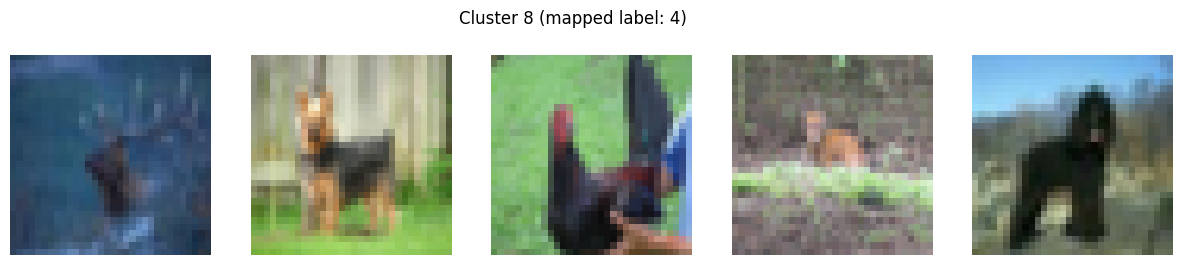

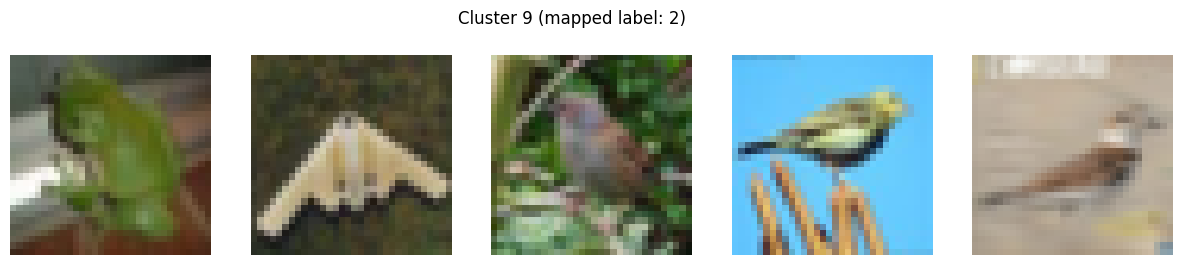

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from collections import Counter
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.models import Model

# -----------------------------
# 1. Load CIFAR-10 và lấy subset
# -----------------------------
# Nguyễn Việt Quang B22DCCN650
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
num_images = 10000  # số ảnh dùng để demo
x_data = x_test[:num_images]
y_data = y_test[:num_images].flatten()
print("Subset data shape:", x_data.shape)  # (10000, 32, 32, 3)

# -----------------------------
# 2. Resize 32x32 -> 224x224 và preprocess
# -----------------------------
# Nguyên Việt Quang B22DCCN650
x_resized = np.array([np.array(array_to_img(img).resize((224,224))) for img in x_data])
x_resized = preprocess_input(x_resized.astype('float32'))
print("Data shape after resize & preprocess:", x_resized.shape)  # (2000, 224, 224, 3)

# -----------------------------
# 3. Load ResNet50 pretrained + trích xuất feature
# Nguyễn Việt Quang B22DCCN650
# -----------------------------
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224,224,3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Giảm batch_size để chạy trên laptop CPU
features = feature_extractor.predict(x_resized, batch_size=16, verbose=1)
print("Feature matrix shape:", features.shape)  # (2000, 2048)

# -----------------------------
# 4. K-means phân cụm
# -----------------------------
# Nguyễn Việt Quang B22DCCN650
k = 10  # CIFAR-10 có 10 lớp
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(features)
print("K-means done. Labels shape:", labels.shape)

# -----------------------------
# 5. Map cluster -> nhãn phổ biến nhất và tính accuracy
# -----------------------------
cluster_to_label = {}
for i in range(k):
    idx = np.where(labels == i)[0]
    most_common = Counter(y_data[idx]).most_common(1)[0][0]
    cluster_to_label[i] = most_common

# Dự đoán nhãn dựa trên cluster
y_pred = np.array([cluster_to_label[cl] for cl in labels])

# Tính accuracy
accuracy = np.mean(y_pred == y_data)
print("Clustering accuracy:", accuracy)

# Optional: Silhouette Score để đánh giá clustering
sil_score = silhouette_score(features, labels)
print("Silhouette score:", sil_score)

# -----------------------------
# 6. Visualize phân cụm bằng PCA 2D
# -----------------------------
# Nguyễn Việt Quang B22DCCN650
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

plt.figure(figsize=(8,6))
scatter = plt.scatter(features_2d[:,0], features_2d[:,1], c=labels, cmap='tab10', s=10)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("CIFAR-10 Clustering (Subset 2000 images)")
plt.show()

# -----------------------------
# 7. Hiển thị 5 ảnh tiêu biểu của từng cụm
# -----------------------------
# Nguyễn Việt Quang B22DCCN650
def show_cluster_images(x_data, labels, cluster_id, n_images=5):
    idx = np.where(labels == cluster_id)[0]
    selected_idx = idx[:n_images]
    plt.figure(figsize=(15,3))
    for i, img_idx in enumerate(selected_idx):
        plt.subplot(1, n_images, i+1)
        plt.imshow(x_data[img_idx].astype('uint8'))
        plt.axis('off')
    plt.suptitle(f'Cluster {cluster_id} (mapped label: {cluster_to_label[cluster_id]})')
    plt.show()

for cluster_id in range(k):
    show_cluster_images(x_data, labels, cluster_id, n_images=5)
